### Configuration de notre environnement

In [2]:
%pip install langgraph langchain_ollama

Note: you may need to restart the kernel to use updated packages.


### Imports des modules nécessaires

In [3]:
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_ollama import OllamaLLM
from langchain_core.messages import HumanMessage, SystemMessage

### Étape 1 : Définir notre état

In [4]:
class EmailState(TypedDict):
    # L'email en cours de traitement
    email: Dict[str, Any]  # Contient sujet, expéditeur, corps, etc.

    # Catégorie de l'email (enquête, plainte, etc.)
    email_category: Optional[str]

    # Raison pourquoi l'email a été marqué comme spam
    spam_reason: Optional[str]

    # Analyse et décisions
    is_spam: Optional[bool]
    
    # Génération de réponse
    email_draft: Optional[str]
    
    # Métadonnées de traitement
    messages: List[Dict[str, Any]]  # Suivre la conversation avec le LLM pour l'analyse

In [5]:
# Initialiser notre LLM
model = OllamaLLM(model="gpt-oss:latest", temperature=0.0)
# Test basique du LLM
print("Test du LLM...")
test_response = model.invoke([HumanMessage(content="Yo")])
print(f"Test réponse: {test_response}")
print(f"Type de la réponse: {type(test_response)}")

Test du LLM...
Test réponse: Hey there! 👋 How can I help you today?
Type de la réponse: <class 'str'>


###  Étape 2 : Définir nos nœuds

In [6]:
def read_email(state: EmailState):
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}


def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler of Mr wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr wayne's attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only return the answer
Answer :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    response_text = response.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response}
        ]
    else:
        new_messages = state.get("messages", [])

    return {
        "is_spam": is_spam,
        "messages": new_messages
    }


def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}


def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response}
    ]

    return {
        "email_draft": response,
        "messages": new_messages
    }


def notify_mr_wayne(state: EmailState):
    email = state["email"]

    print("\n" + "=" * 50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")

    return {}


# Définir la logique de routage
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"


# Créer le graphe
email_graph = StateGraph(EmailState)

# Ajouter des nœuds
email_graph.add_node("read_email", read_email)  # le nœud read_email exécute la fonction read_mail
email_graph.add_node("classify_email", classify_email)  # le nœud classify_email exécutera la fonction classify_email
email_graph.add_node("handle_spam", handle_spam)  # même logique
email_graph.add_node("drafting_response", drafting_response)  # même logique
email_graph.add_node("notify_mr_wayne", notify_mr_wayne)  # même logique


# def read_email(state: EmailState):
#     email = state["email"]
#     print(f"Alfred traite un email de {email['sender']} avec le sujet : {email['subject']}")
#     return {}


# def classify_email(state: EmailState):
#     email = state["email"]

#     prompt = f"""
# En tant qu'Alfred le majordome de M. Wayne et son identité SECRÈTE Batman, analysez cet email et déterminez s'il s'agit de spam ou s'il est légitime et doit être porté à l'attention de M. Wayne.

# Email :
# De : {email['sender']}
# Sujet : {email['subject']}
# Corps : {email['body']}

# Premièrement, déterminez si cet email est du spam.
# Répondez avec SPAM ou HAM s'il est légitime. Retournez uniquement la réponse.
# Réponse :
#     """
#     messages = [HumanMessage(content=prompt)]
#     response = model.invoke(messages)

#     response_text = response.lower()
#     print(response_text)
#     is_spam = "spam" in response_text and "ham" not in response_text

#     if not is_spam:
#         new_messages = state.get("messages", []) + [
#             {"role": "user", "content": prompt},
#             {"role": "assistant", "content": response}
#         ]
#     else:
#         new_messages = state.get("messages", [])

#     return {
#         "is_spam": is_spam,
#         "messages": new_messages
#     }


# def handle_spam(state: EmailState):
#     print(f"Alfred a marqué l'email comme spam.")
#     print("L'email a été déplacé dans le dossier spam.")
#     return {}


# def drafting_response(state: EmailState):
#     email = state["email"]

#     prompt = f"""
# En tant qu'Alfred le majordome, rédigez une réponse préliminaire polie à cet email.

# Email :
# De : {email['sender']}
# Sujet : {email['subject']}
# Corps : {email['body']}

# Rédigez une réponse brève et professionnelle que M. Wayne peut réviser et personnaliser avant l'envoi.
#     """

#     messages = [HumanMessage(content=prompt)]
#     response = model.invoke(messages)

#     new_messages = state.get("messages", []) + [
#         {"role": "user", "content": prompt},
#         {"role": "assistant", "content": response}
#     ]

#     return {
#         "email_draft": response,
#         "messages": new_messages
#     }


# def notify_mr_wayne(state: EmailState):
#     email = state["email"]

#     print("\n" + "=" * 50)
#     print(f"Monsieur, vous avez reçu un email de {email['sender']}.")
#     print(f"Sujet : {email['subject']}")
#     print("\nJ'ai préparé un brouillon de réponse pour votre révision :")
#     print("-" * 50)
#     print(state["email_draft"])
#     print("=" * 50 + "\n")

#     return {}


# # Définir la logique de routage
# def route_email(state: EmailState) -> str:
#     if state["is_spam"]:
#         return "spam"
#     else:
#         return "legitimate"


# # Créer le graphe
# email_graph = StateGraph(EmailState)

# # Ajouter des nœuds
# email_graph.add_node("read_email", read_email)  # le nœud read_email exécute la fonction read_email
# email_graph.add_node("classify_email", classify_email)  # le nœud classify_email exécutera la fonction classify_email
# email_graph.add_node("handle_spam", handle_spam)  # même logique
# email_graph.add_node("drafting_response", drafting_response)  # même logique
# email_graph.add_node("notify_mr_wayne", notify_mr_wayne)  # même logique

###  Étape 3 : Définir notre logique de routage

In [7]:
# Ajouter des arêtes
email_graph.add_edge(START, "read_email")  # Après le départ, nous accédons au nœud « read_email »

email_graph.add_edge("read_email", "classify_email")  # after_reading nous classifions

# Ajouter des arêtes conditionnelles
email_graph.add_conditional_edges(
    "classify_email",  # après la classification, nous exécutons la fonction « route_email »
    route_email,
    {
        "spam": "handle_spam",  # s'il renvoie « Spam », nous allons au noeud « handle_span »
        "legitimate": "drafting_response"  # et s'il est légitime, nous passons au nœud « drafting_response »
    }
)

# Ajouter les arêtes finales
email_graph.add_edge("handle_spam", END)  # après avoir traité le spam, nous terminons toujours
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END)  # après avoir notifié M. Wayne, nous pouvons mettre un terme à l'opération


###  Étape 4 : Créer le StateGraph et définir les arêtes

In [8]:
# Compiler le graphique
compiled_graph = email_graph.compile()

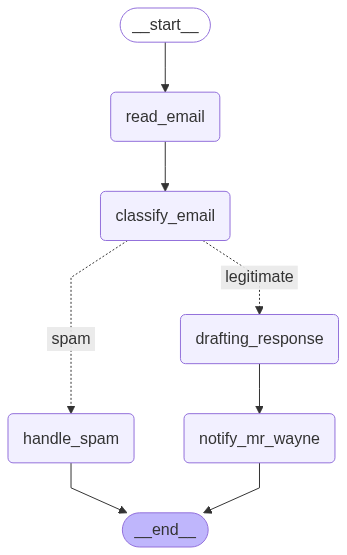

In [9]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [15]:
#  # Exemple de courriels à tester
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman ! ",
    "body": "Mr. Wayne,I found your secret identity ! I know you're batman ! Ther's no denying it, I have proof of that and I'm coming to find you soon. I'll get my revenge. JOKER"
}

legitimate_email2 = {
    "sender": "FIFA News",
    "subject": "Champions League Highlights",
    "body": "Hello,\n\nCatch up on last night's Champions League matches! Real Madrid secured a dramatic 2-1 win against Manchester City, while Barcelona dominated PSG with a 3-0 victory. Visit our website for full match highlights, stats, and expert analysis.\n\nBest,\nFIFA News Team"
}


spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Traiter les emails légitimes
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email2,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


# Traiter les spams
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Exemple de courriels à tester
# legitimate_email = {
#     "sender": "Joker",
#     "subject": "Je t'ai trouvé Batman !",
#     "body": "M. Wayne, j'ai découvert votre identité secrète ! Je sais que vous êtes Batman ! Il n'y a pas de déni possible, j'ai la preuve et je viens vous chercher bientôt. J'aurai ma revanche. JOKER"
# }

# spam_email = {
#     "sender": "Crypto bro",
#     "subject": "Le meilleur investissement de 2025",
#     "body": "M. Wayne, je viens de lancer une crypto-monnaie alternative et je veux que vous en achetiez !"
# }

# # Traiter les emails légitimes
# print("\nTraitement de l'email légitime...")
# legitimate_result = compiled_graph.invoke({
#     "email": legitimate_email,
#     "is_spam": None,
#     "spam_reason": None,
#     "email_category": None,
#     "email_draft": None,
#     "messages": []
# })

# # Traiter les spams
# print("\nTraitement de l'email spam...")
# spam_result = compiled_graph.invoke({
#     "email": spam_email,
#     "is_spam": None,
#     "spam_reason": None,
#     "email_category": None,
#     "email_draft": None,
#     "messages": []
# })


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 


ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Found you Batman !

Dear Mr. Joker,

Thank you for your message. I understand your concerns and assure you that Mr. Wayne is fully aware of the situation. He will address this matter in due course.

Please let me know if there is anything else I can do to assist.

Yours sincerely,

Alfred

---  
Feel free to adjust the wording or add any additional details before sending.


Processing legitimate email...
Alfred is processing an email from FIFA News with subject: Champions League Highlights
answer : ham

Sir, you've received an email from FIFA News.
Subject: Champions League Highlights

I've prepared a draft response for your review:
--------------------------------------------------
**Draft Response**

Dear FIFA News Team,

Thank you for the update on last night's Champions League matches. We appreci

In [11]:
%pip install -q langfuse

Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install langchain

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
 
# Obtenez les clés pour votre projet depuis la page des paramètres du projet : https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-"
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # 🇪🇺 région EU
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 région US

In [16]:
from langfuse.langchain import CallbackHandler

# Initialiser le CallbackHandler Langfuse pour LangGraph/Langchain (traçage)
langfuse_handler = CallbackHandler()

# Traiter l'email légitime
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email2, "is_spam": None, "spam_reason": None, "email_category": None, "draft_response": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

Alfred is processing an email from FIFA News with subject: Champions League Highlights


answer : ham

Sir, you've received an email from FIFA News.
Subject: Champions League Highlights

I've prepared a draft response for your review:
--------------------------------------------------
**Draft Response**

Dear FIFA News Team,

Thank you for the update on last night's Champions League matches. We appreciate the comprehensive coverage and will be sure to visit your website for the full highlights and analysis. Please keep us informed of any upcoming fixtures or exclusive content.

Kind regards,

Alfred  
(Prepared for Mr. Wayne’s review and personalisation)

